In [1]:
!pip install qiskit

In [2]:
!pip install qiskit_aer

In [3]:
!pip install qiskit_machine_learning

In [4]:
!pip install qiskit_ibm_runtime

In [5]:
!pip install pylatexenc

In [6]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from qiskit import *
from qiskit.circuit.library import ZZFeatureMap

from qiskit.circuit.library import TwoLocal

from qiskit_aer import AerSimulator
from qiskit.primitives import Sampler, BackendSampler

from qiskit_ibm_runtime.fake_provider import FakeVigo
from qiskit_aer.noise import NoiseModel

import matplotlib.pyplot as plt
from IPython.display import clear_output
from qiskit.visualization import plot_histogram
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.providers.fake_provider import GenericBackendV2

In [7]:
#データの準備
iris = datasets.load_iris()
df = pd.DataFrame(iris.data,
                  columns = iris.feature_names)
feature = iris.data
target = iris.target

#学習に使う変数の数
feature_dim = 4

#データを訓練用と検証用に分割
x_train, x_test, y_train, y_test = train_test_split(feature,
                                                    target,
                                                    train_size = 0.7)

#ラベルデータをOne-hotベクトルに変換
y_train = np.eye(3)[y_train]
y_test = np.eye(3)[y_test]

#正規化
mms = MinMaxScaler((0, 1))
norm_train_data = mms.fit_transform(x_train)
norm_test_data = mms.transform(x_test)

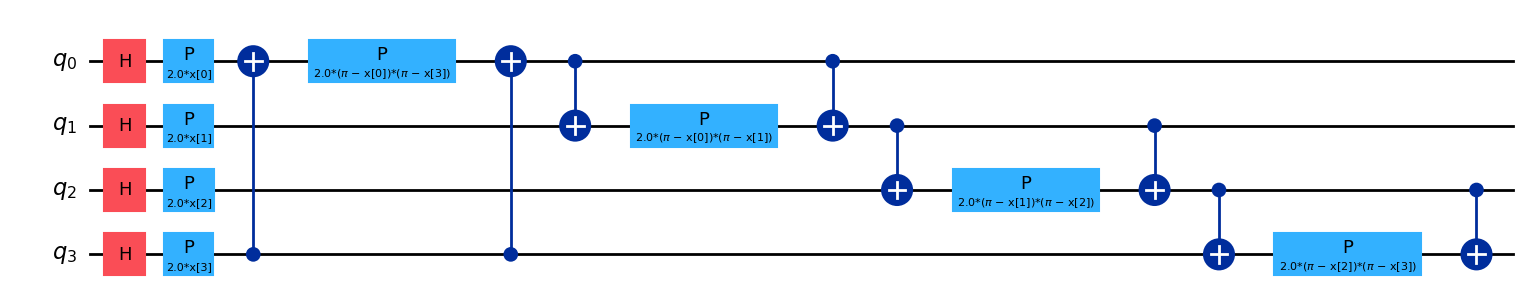

In [8]:
#特徴量マップの生成
feature_map = ZZFeatureMap(feature_dimension = feature_dim,
                           reps = 1,
                           entanglement = 'circular')
feature_map.decompose().draw('mpl')

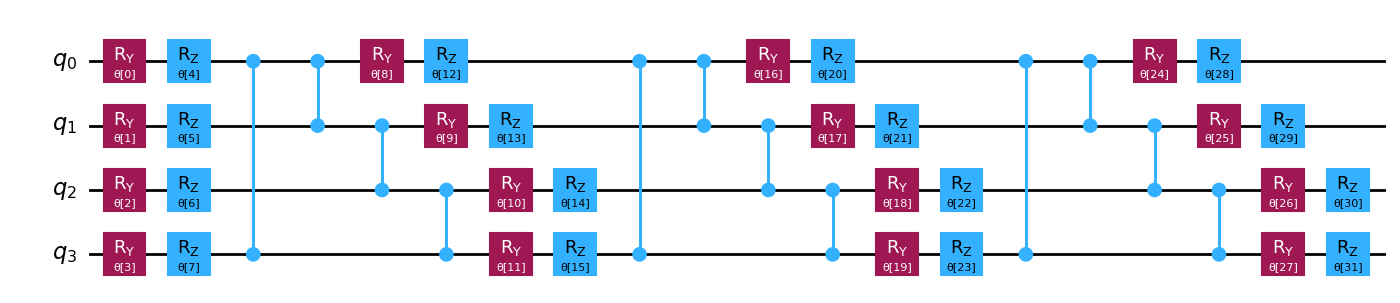

In [9]:
#変分量子回路を用いた状態変換
ansatz = TwoLocal(num_qubits = feature_dim,
                  rotation_blocks = ['ry', 'rz'],
                  entanglement_blocks = 'cz',
                  entanglement = 'circular',
                  reps = 3)
ansatz.decompose().draw('mpl')

In [10]:
#ノイズのあるバックエンドの指定
backend = GenericBackendV2(num_qubits=5)
noise_model = NoiseModel.from_backend(backend)
basis_gates = noise_model.basis_gates

#シミュレータの指定
backend = AerSimulator(noise_model = noise_model,
                       basis_gates = basis_gates)
sampler = BackendSampler(backend = backend)

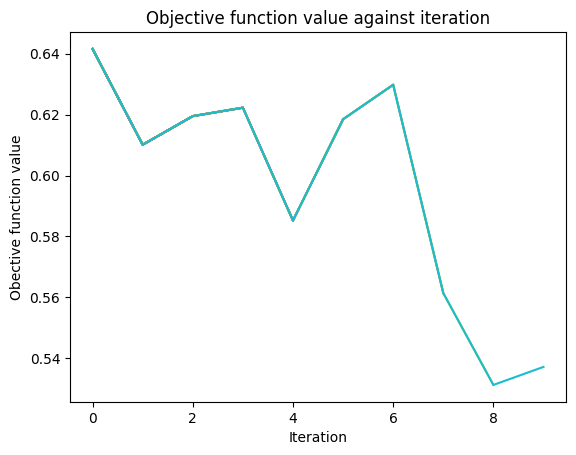

In [11]:
#パラメータの更新回数
maxiter = 10
tol = 0.00000000001

#最適化手法
optimizer = COBYLA(maxiter = maxiter,
                   disp = True,
                   tol = tol,
                   rhobeg = 0.5)
#目的関数を格納する配列
objective_func_vals = []

#コールバック関数の定義
def callback_graph(weights, obj_func_eval):
  clear_output(wait = True)
  objective_func_vals.append(obj_func_eval)

  plt.title("Objective function value against iteration")
  plt.xlabel("Iteration")
  plt.ylabel("Obective function value")
  plt.plot(objective_func_vals)

#VQCの内容
vqc = VQC(num_qubits = feature_dim,
          feature_map = feature_map,
          ansatz = ansatz,
          loss = "squared_error",
          optimizer = optimizer,
          callback = callback_graph,
          sampler = sampler)

#学習
vqc.fit(norm_train_data, y_train)
train_score = vqc.score(norm_train_data, y_train)
test_score = vqc.score(norm_test_data, y_test)

In [12]:
print(f'---Classification Train Score: {train_score} ---')
print(f'---Classification Test Score: {test_score} ---')

---Classification Train Score: 0.6952380952380952 ---
---Classification Test Score: 0.6666666666666666 ---


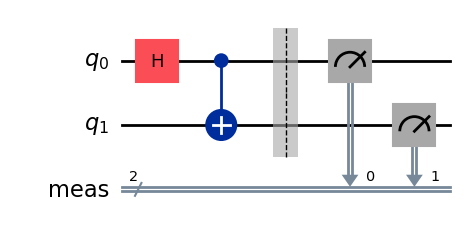

In [13]:
#テスト用簡易量子回路
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()
qc.draw('mpl')

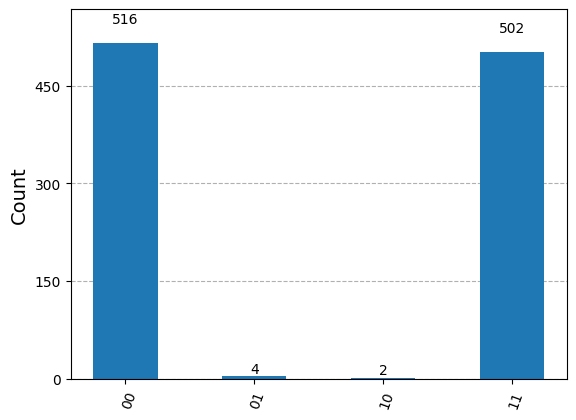

In [14]:
#テスト用簡易量子回路の測定
transpiled_circuit = transpile(qc, backend)
result = backend.run(transpiled_circuit).result()

counts = result.get_counts(0)
plot_histogram(counts)